<!-- Notebook Header Start -->

<h1 align="center">Changes to Noxious Stimuli by means of Dorsal Root Ganglion Stimulation</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2025-04-26<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Importing libraries & data**
* **Preprocess neurophysiology recordings for spike sorting**
* **Package preprocessed data for spike sorting using Kilosort4**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during noxious stimuli**
* **Compare the firing rates of clusters before and after noxious stimuli**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# ➡ Importing Libraries & Data
---

In [34]:
# standard imports
from pathlib import Path
import os
from kilosort import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots
from automations import analysis_functions


### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

I am running my latest analysis, but with Charlie's probe to make sure that I am doing this right

In [35]:
PROBE_DIRECTORY = Path(r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32_max_murphy_probe.prb")

### filepath definitions

In [36]:
# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# save data to the inbox; make sure that the folders: binary & figures exist

# select your path

# the following save directory has already been run, and it stores data that has been unaltered
SAVE_DIRECTORY = Path(fr"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.016 Multi_Rat_Linear_Mixed_Effects_max_probe_noflex")

# Create paths if they don't exist
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)

# run a multi-rat class

In [37]:
# all trials
rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW322', 'DW323', 'DW327','DW361']]

# just the one I want for now. you need to pass it as a list, even if it's just one
# rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW361']]

group = RM1.RatGroup(rats)
group.run_preprocessing(remove_drg_stim=True)  # preprocess all rats at once

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233: stream_id 2 is not in ['0', '1', '3', '4']
Re

In [38]:
group.rats.keys()

dict_keys(['DW322', 'DW323', 'DW327', 'DW361'])

## run spikeinterface

20250411 update: I am using the bandpass filter (300 Hz - 3000 Hz) from Ting et al. 2024 and the notch filter (60Hz) from Wang et al. 2024

I am using 60 Hz instead of 50 Hz because Wang et al. 2024 was in China, and the supplied power is 50 Hz, and in the US it is 60 Hz

In [39]:
si_wrappers = group.create_spikeinterface_wrappers(SAVE_DIRECTORY)
for rat_id in si_wrappers.keys():
    # si_wrappers[rat_id].save_spinalcord_data_to_binary(bandpass_freq_min=300, bandpass_freq_max=3000, notch_freq=60)
    pass

Preparing SpikeInterface wrapper for rat DW322
Preparing SpikeInterface wrapper for rat DW323
Preparing SpikeInterface wrapper for rat DW327
Preparing SpikeInterface wrapper for rat DW361


## run kilosort

In [40]:
ks_wrappers = group.create_kilosort_wrappers(SAVE_DIRECTORY, probe_directory=PROBE_DIRECTORY)
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):   
    # Example criteria: Contamination rate < 15% and firing rate between 0.1 and 1000 Hz
    contam_good = est_contam_rate < 0.15
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.1 <= fr <= 1000:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

Preparing Kilosort wrapper for DW322
Preparing Kilosort wrapper for DW323
Preparing Kilosort wrapper for DW327
Preparing Kilosort wrapper for DW361


In [41]:
for rat_id in ks_wrappers.keys():
    # ks_wrappers[rat_id].run_kilosort_trial_summary(new_settings="vf_settings",custom_criteria=my_custom_criteria)
    ks_wrappers[rat_id].extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_1_240918_143256
Kilosort outputs successfully loaded for trial: VF_2_240918_143936
Kilosort outputs successfully loaded for trial: VF_3_240918_144658
Kilosort outputs successfully loaded for trial: VF_4_240918_145638
Kilosort outputs successfully loaded for trial: VF_5_240918_150137
Kilosort outputs successfully loaded for trial: VF_6_240918_150811
Kilosort outputs successfully loaded for trial: VF_7_240918_151516
Kilosort outputs successfully loaded for trial: VF_8_240918_152056
Kilosort outputs successfully loaded for trial: VF_9_240918_152753
Kilosort outputs successfully loaded for trial: VF_1_240911_164342
Kilosort outputs successfully loaded for trial: VF_2_240911_165039
Kilosort outputs successfully loaded for trial: VF_3_240911_165617
Kilosort outputs successfully loaded for trial: VF_4_240911_170446
Kilosort outputs successfully loaded for trial: VF_5_240911_171014
Kilosort outputs successfully loaded for trial: VF_6_240911_17

### generate sanity plots for each trial 

In [42]:
dw322_trials = ["VF_1_240918_143256","VF_2_240918_143936","VF_3_240918_144658","VF_4_240918_145638","VF_5_240918_150137","VF_6_240918_150811",
                "VF_7_240918_151516","VF_8_240918_152056","VF_9_240918_152753"]

dw323_trials = ["VF_1_240911_164342","VF_2_240911_165039","VF_3_240911_165617","VF_4_240911_170446","VF_5_240911_171014","VF_6_240911_171505"]

dw327_trials = ["VF_01_241125_153746","VF_02_241125_154307","VF_03_241125_154841","VF_04_241125_155417","VF_05_241125_155941","VF_06_241125_160515",
                "VF_07_241125_161126","VF_08_241125_161626","VF_09_241125_162141","VF_10_241125_162725"]

dw361_trials = ["VF_1_250422_124925","VF_2_250422_125146","VF_3_250422_125632","VF_4_250422_130213","VF_5_250422_130729","VF_6_250422_131240",
                "VF_7_250422_131739","VF_8_250422_132231","VF_9_250422_132717","VF_10_250422_133218","VF_11_250422_133722","VF_12_250422_134214",
                "VF_13_250422_134725","VF_14_250422_154410","VF_14_250422_154410","VF_15_250422_154935","VF_16_250422_155509"]

##### NOTE:

seeing repeating units is not a sign that there is an issue: these plots a pick random units, (40) times, to show how spikes are captured on the probe. 

the fewer the number of good or mua units, the more likely there will be repeated units.

#### DW322

In [43]:
# ks_wrappers["DW322"].plot_trial_results(dw322_trials)

#### DW323

In [44]:
# ks_wrappers["DW323"].plot_trial_results(dw323_trials)

#### DW327

In [45]:
# ks_wrappers["DW327"].plot_trial_results(dw327_trials)

#### DW361

In [46]:
# ks_wrappers["DW361"].plot_trial_results(dw361_trials)

### plot characteristic waveform for each neuron

#### DW322

In [47]:
# ks_wrappers["DW322"].plot_cluster_waveforms(dw322_trials)

#### DW323

In [48]:
# ks_wrappers["DW323"].plot_cluster_waveforms(dw323_trials)

#### DW327

In [49]:
# ks_wrappers["DW327"].plot_cluster_waveforms(dw327_trials)

#### DW361

In [50]:
# ks_wrappers["DW361"].plot_cluster_waveforms(dw361_trials)

### multi-animal von frey analysis

In [51]:
# Create a multi–rat analysis instance.
multi_analysis = analysis_functions.MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)

# combine all the trials from every animal to plot the results

combined_results = multi_analysis.analyze_all_trials(excel_parent_folder=SAVE_DIRECTORY, subwindow_width=0.5, corr_threshold=0.01)

# use combined_results for further plotting or modeling.

# combined_results now contains results from each rat, loaded from Excel if available.

In [52]:
combined_results["DW322_VF_2_240918_143936"]

{'voltage_df':      avg_voltage      group
 0   272278.37500   pre-stim
 1   289338.81250   pre-stim
 2   274101.43750   pre-stim
 3   227150.00000   pre-stim
 4   288529.34375   pre-stim
 ..           ...        ...
 65  617659.06250  post-stim
 66  664856.37500  post-stim
 67  763105.62500  post-stim
 68  820236.31250  post-stim
 69  646114.18750  post-stim
 
 [70 rows x 2 columns],
 'firing_df':        Unnamed: 0           0          1          2           3         4  \
 0               0   72.000000  46.000000  66.000000   76.000000  0.000000   
 1               1   52.000000  42.000000  38.000000   64.000000  0.000000   
 2               2   19.579689  46.991254  19.579689    0.000000  0.000000   
 3               3  150.000000   0.000000   0.000000    0.000000  0.000000   
 4               4  114.000000  38.000000  96.000000   94.000000  0.000000   
 ..            ...         ...        ...        ...         ...       ...   
 67             67   90.000000  68.000000  56.000000 

Combine the Results and Metadata:
You would need to create (or extract) a DataFrame where each row corresponds to a sub-window (or trial) with columns for the dependent variable (for example, average voltage), the fixed effects (e.g. stimulation, pulse width, waiting), and a column indicating the animal (rat ID). You might need to merge your VonFreyAnalysis results with metadata that specifies stimulation parameters.

Fit a Mixed Effects Model:
Use the statsmodels MixedLM or the formula interface (statsmodels.formula.api.mixedlm) to specify a model with fixed effects for voltage, stimulation, pulse width, waiting and a random intercept for animal.


### example of single-rat experiment properties

In [53]:
group.rats["DW323"].qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,NaN
Trial Number,,,,,,,,,,,
1,1,VF,70,300,5,180,vf,NaN,30,pos 1,pad just prximal from toe
2,2,VF,70,300,20,180,vf,NaN,30,pos 1,NaN
3,3,VF,70,300,100,180,vf,NaN,30,pos 1,NaN
4,4,VF,70,300,100,180,vf,NaN,30,pos 2,toes
5,5,VF,70,300,5,180,vf,NaN,30,pos 2,NaN
6,6,VF,70,300,20,180,vf,NaN,30,pos 2,NaN


### combining the experiment notes for individual animals, for combined plots and linear mixed effects modeling.

In [54]:
def make_unique_cols(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    df.columns = new_cols
    return df

dfs = []
for rat_id, rat in group.rats.items():
    df = make_unique_cols(rat.qst_trial_notes.copy())
    df['Rat ID'] = rat_id
    df["Trial Number"] = rat_id + "_" + df["Trial Number"].astype(str)
    dfs.append(df)

combined_qst_notes = pd.concat(dfs, ignore_index=True)

# Sort keys based on the numeric part after the second underscore (i.e., the zero-padded trial number)
sorted_keys = sorted(
    combined_results.keys(),
    key=lambda x: int(x.split('_')[2])
)

combined_qst_notes['Trial_ID'] = sorted_keys

# After concatenating your DataFrames into combined_qst_notes:
combined_qst_notes['Trial_ID'] = list(combined_results.keys())
combined_qst_notes

,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,Rat ID,nan_1,Trial_ID
0,DW322_1,VF,51,300,5,180,vf,NaN,30,accidentally named DRGS_13,DW322,NaN,DW322_VF_1_240918_143256
1,DW322_2,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_2_240918_143936
2,DW322_3,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_3_240918_144658
3,DW322_4,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_4_240918_145638
4,DW322_5,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_5_240918_150137
5,DW322_6,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_6_240918_150811
6,DW322_7,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_7_240918_151516
7,DW322_8,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_8_240918_152056
8,DW322_9,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_9_240918_152753
9,DW323_1,VF,70,300,5,180,vf,NaN,30,pos 1,DW323,pad just prximal from toe,DW323_VF_1_240911_164342


## plot a composite Von Frey Analysis plot

Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_6_240918_150811. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_

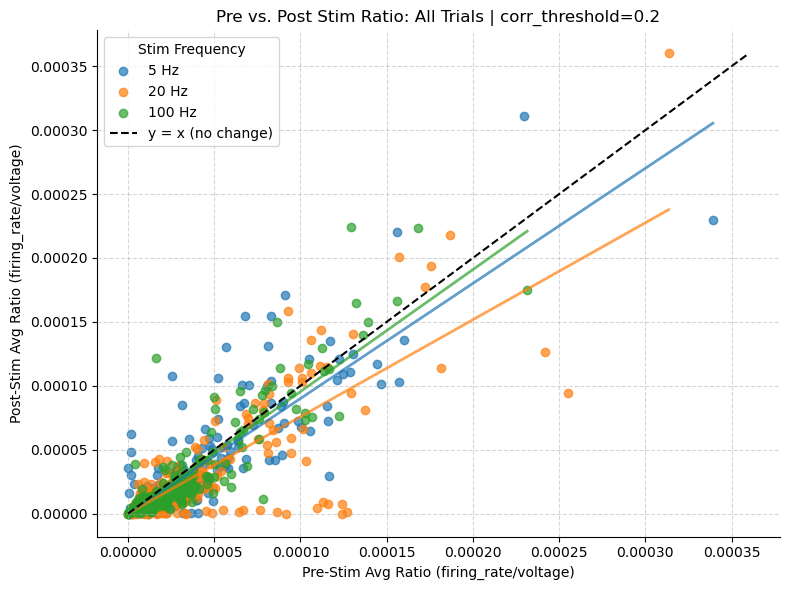

In [ ]:
# For example:
plots.vf_all_trials_combined_plot(combined_results, combined_qst_notes,corr_threshold=0.4)

In [ ]:
broke the code here

## combine metadata and neuron firing changes for linear effects mixed model

In [56]:
def flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.1):
    """
    Flattens trial data into a single DataFrame, then filters clusters by correlation threshold.
    Only clusters whose absolute correlation meets or exceeds corr_threshold are kept.
    """
    # Create dictionaries for columns you need from combined_qst_notes
    freq_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Freq. (Hz)']))
    amp_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['amp']))
    # Add a rat_id_dict to capture the rat ID from combined_qst_notes
    rat_id_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Rat ID']))
    pulse_width_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['PW (us)']))



    records = []

    for trial_id, res in combined_results.items():
        # Get frequency and amplitude
        freq_hz = freq_dict.get(trial_id)
        amp_val = amp_dict.get(trial_id)
        rat_id = rat_id_dict.get(trial_id)
        pulse_width = pulse_width_dict.get(trial_id)

        if freq_hz is None or amp_val is None or rat_id is None or pulse_width is None:
            continue

        avg_voltage_df = res.get('voltage_df')
        firing_rates_df = res.get('firing_df')
        if avg_voltage_df is None or firing_rates_df is None:
            continue
        
        # Skip if not enough rows to have correlation data
        if len(firing_rates_df) < 2:
            continue

        # Extract the correlation row (second-to-last row)
        correlation_data = firing_rates_df.iloc[-2]
        # Convert correlation entries to a dictionary keyed by integer cluster IDs
        corr_dict = {
            int(k): v
            for k, v in correlation_data.to_dict().items()
            if str(k).isdigit()
        }

        # Exclude the last two rows (correlation row, plus any extra row if present)
        firing_data = firing_rates_df.iloc[:-2]

        # Melt the firing data to long format: (group, cluster, firing_rate)
        firing_melt = firing_data.melt(
            id_vars=['group'], 
            var_name='cluster', 
            value_name='firing_rate'
        )
        firing_melt['cluster'] = pd.to_numeric(firing_melt['cluster'], errors='coerce')

        # Merge firing data with average voltage on group
        if "avg_voltage" not in avg_voltage_df.columns:
            continue
        merged_df = pd.merge(
            firing_melt,
            avg_voltage_df[["group", "avg_voltage"]],
            on="group",
            how="left"
        )

        # Map correlation values per cluster
        merged_df['correlation'] = merged_df['cluster'].map(corr_dict)

        # Add identifying columns
        merged_df['Trial_ID'] = trial_id
        merged_df['Frequency_Hz'] = freq_hz
        merged_df['Amplitude'] = amp_val
        merged_df["Pulse_Width(us)"] = pulse_width
        # normalize the results by dividing by average voltage
        merged_df["firing_rate_vs_stim(uV^-1)"] = merged_df['Frequency_Hz'] / merged_df["avg_voltage"]
        merged_df['Rat_ID'] = rat_id

        # if I need to further flatten the dataset
        merged_df['cluster'] = merged_df['cluster'].astype(str) + "-" + merged_df["Trial_ID"].astype(str)
        
        # Collect all in a list
        records.append(merged_df)

    # Combine all into a single DataFrame
    if not records:
        return pd.DataFrame()

    final_long_df = pd.concat(records, ignore_index=True)

    # Filter by correlation threshold. Keep only those meeting abs corr >= threshold
    final_long_df = final_long_df[final_long_df['correlation'].abs() >= corr_threshold]

    return final_long_df


lmem = flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.01)
lmem.to_csv(SAVE_DIRECTORY / "flattened_data.csv")
lmem

,group,cluster,firing_rate,avg_voltage,correlation,Trial_ID,Frequency_Hz,Amplitude,Pulse_Width(us),firing_rate_vs_stim(uV^-1),Rat_ID
2592,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226600.000000,0.346788,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2593,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226881.562500,0.346788,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2594,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,243538.781250,0.346788,DW322_VF_1_240918_143256,5,51,300,0.000021,DW322
2595,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226158.921875,0.346788,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2596,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,251939.531250,0.346788,DW322_VF_1_240918_143256,5,51,300,0.000020,DW322
...,...,...,...,...,...,...,...,...,...,...,...
4120945,post-stim,63.0-DW361_VF_9_250422_132717,0.0,910934.375000,0.240933,DW361_VF_9_250422_132717,100,69,300,0.000110,DW361
4120946,post-stim,63.0-DW361_VF_9_250422_132717,0.0,524329.312500,0.240933,DW361_VF_9_250422_132717,100,69,300,0.000191,DW361
4120947,post-stim,63.0-DW361_VF_9_250422_132717,0.0,607562.937500,0.240933,DW361_VF_9_250422_132717,100,69,300,0.000165,DW361
4120948,post-stim,63.0-DW361_VF_9_250422_132717,0.0,581997.500000,0.240933,DW361_VF_9_250422_132717,100,69,300,0.000172,DW361


### getting a better look at the force distribution:

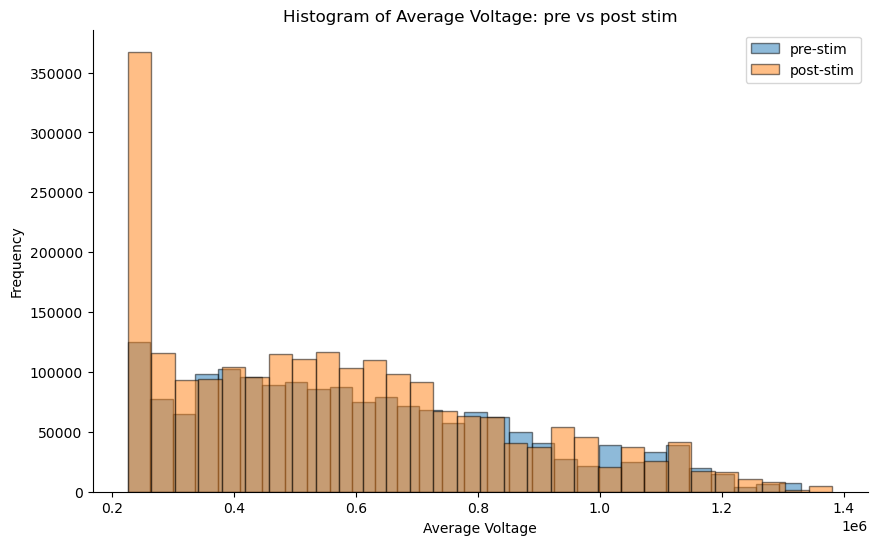

C:\Users\Karl\AppData\Local\Temp\ipykernel_25368\3856836436.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])


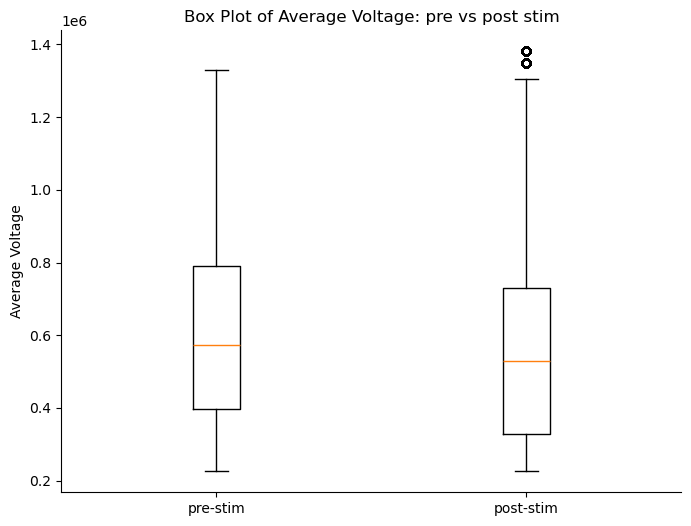

In [57]:

# histogram

pre_data = lmem[lmem['group'] == 'pre-stim']['avg_voltage']
post_data = lmem[lmem['group'] == 'post-stim']['avg_voltage']

plt.figure(figsize=(10, 6))
plt.hist(pre_data, bins=30, alpha=0.5, label='pre-stim', edgecolor='black')
plt.hist(post_data, bins=30, alpha=0.5, label='post-stim', edgecolor='black')
plt.title('Histogram of Average Voltage: pre vs post stim')
plt.xlabel('Average Voltage')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# boxplot

plt.figure(figsize=(8, 6))
data_to_plot = [
    pre_data,
    post_data
]
plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])
plt.title('Box Plot of Average Voltage: pre vs post stim')
plt.ylabel('Average Voltage')
plt.show()


it honestly doesn't look too different - what could the issue be??

### grouping the dataset by "bins" of stimulus

In [58]:

# 1. Define bin edges: we go from 0 to slightly above the max value in steps of 50,000.
max_val = lmem['avg_voltage'].max()
bin_edges = np.arange(0, max_val + 10000, 10000)

# 2. Create labels that match the upper bound of each bin.
#    For instance, bin [0, 50000] gets the label "50000", bin (50000, 100000] gets "100000", etc.
labels = [str(int(x)) for x in bin_edges[1:]]

# 3. Use pd.cut to discretize avg_voltage. 
#    include_lowest=True ensures that 0 goes into the first bin. 
#    With right=True (the default), intervals are (a, b], so 50,000 falls in the first bin.
lmem['voltage_bin'] = pd.cut(lmem['avg_voltage'], 
                           bins=bin_edges, 
                           labels=labels, 
                           include_lowest=True,
                           right=True)

# Now each row has a "voltage_bin" indicating its bin.


# see bin counts
bin_counts = lmem['voltage_bin'].value_counts().sort_index()
print("Number of entries in each bin (uV):")
print(bin_counts)


Number of entries in each bin (uV):
voltage_bin
10000         0
20000         0
30000         0
40000         0
50000         0
           ... 
1350000    2210
1360000       0
1370000       0
1380000       0
1390000    2210
Name: count, Length: 139, dtype: int64


In [59]:
# Group by 'cluster' and 'voltage_bin' then calc mean firing rate
avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()
# avg_firing_rate["firing_rate"] = avg_firing_rate["firing_rate"].astype(float) # I think it already does this, no need to specify againa
avg_firing_rate.to_csv(SAVE_DIRECTORY / "grouped_stimulus.csv")
avg_firing_rate

C:\Users\Karl\AppData\Local\Temp\ipykernel_25368\16533545.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()


,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,group,firing_rate
132,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,230000,5,post-stim,30.985737
133,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,230000,5,pre-stim,41.715353
139,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,240000,5,pre-stim,41.715353
144,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,post-stim,30.985737
145,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,pre-stim,41.715353
...,...,...,...,...,...,...,...
209814197,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,1080000,100,pre-stim,10.957747
209814202,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,1090000,100,post-stim,9.905284
209814221,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,1120000,100,pre-stim,10.957747
209814239,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,1150000,100,pre-stim,10.957747


IMPORTANT: this code need to drop zero entries, because you can't calculate % change with zero.

In [60]:
# Pivot the data so that pre-stim and post-stim firing rates become separate columns.
pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],
                          columns='group',
                          values='firing_rate').reset_index()


# Remove rows where pre-stim is zero to avoid division by zero
pre_post_pivot = pre_post_pivot[pre_post_pivot['pre-stim'] != 0]


# Drop rows that do not have both pre-stim and post-stim values
pre_post_pivot = pre_post_pivot.dropna(subset=['pre-stim', 'post-stim'])

# Calc percent change, pre to post
pre_post_pivot['percent_change'] = ((pre_post_pivot['post-stim'] - pre_post_pivot['pre-stim']) / pre_post_pivot['pre-stim']) * 100

pre_post_pivot.to_csv(SAVE_DIRECTORY / "percent_change.csv")

pre_post_pivot


C:\Users\Karl\AppData\Local\Temp\ipykernel_25368\397580726.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],


group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
0,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,230000,5,30.985737,41.715353,-25.721025
2,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,30.985737,41.715353,-25.721025
3,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,260000,5,30.985737,41.715353,-25.721025
16,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,450000,5,30.985737,41.715353,-25.721025
20,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,520000,5,30.985737,41.715353,-25.721025
...,...,...,...,...,...,...,...,...
66371,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,920000,100,9.905284,10.957747,-9.604737
66384,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,720000,100,9.905284,10.957747,-9.604737
66385,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,760000,100,9.905284,10.957747,-9.604737
66386,DW361,DW361_VF_9_250422_132717,9.0-DW361_VF_9_250422_132717,800000,100,9.905284,10.957747,-9.604737


### converting the pivoted data to numeric

In [61]:
## voltage bin
# convert category → string → float (invalid entries become NaN)
pre_post_pivot["voltage_bin"] = pd.to_numeric(
    pre_post_pivot["voltage_bin"].astype(str), errors="coerce"
)

## pre-post stim
# turn everything numeric, coerce errors → NaN
for col in ["pre-stim", "post-stim"]:
    pre_post_pivot[col] = pd.to_numeric(pre_post_pivot[col], errors="coerce")

# drop rows that failed conversion or have zero pre‑stim
pre_post_pivot = pre_post_pivot.dropna(subset=["pre-stim", "post-stim"])
pre_post_pivot = pre_post_pivot[pre_post_pivot["pre-stim"] != 0]

## percent change
# recompute percent_change as float
pre_post_pivot["percent_change"] = (
    (pre_post_pivot["post-stim"] - pre_post_pivot["pre-stim"])
    / pre_post_pivot["pre-stim"]
) * 100

In [62]:
print(pre_post_pivot.dtypes.loc[["voltage_bin", "pre-stim",
                                 "post-stim", "percent_change"]])

group
voltage_bin         int64
pre-stim          float64
post-stim         float64
percent_change    float64
dtype: object


# 📊 % Change in Firing Rates, Grouped by Force (force-matched plots)
---

## Idea:
* The goal here is to create a plot similar to what I already have. But what I will do is plot the percent change in firing rate, for each neuron, along a batch of stimulation rates. so essentially, break up the voltage thresholds into a batch of voltage ranges, then group the firing rates in those batches, then plot the difference.

## Steps
1) Break up the voltages into batches of 100,000uV (there should be 4-8 groups within this range)
2) For each neuron, calculate the percent change in firing rate for each neuron, pre & post stimulation
3) plot the percent change on the y axis. do this for every neuron in the group. 
4) plot the percent change for each neuron to the color representing it's DRG stimulation frequency (5Hz, 20Hz, 100Hz)
5) draw a trendline for the percent change for each neuron (make the colors very similar to what I was using for the previous plot)

the percent change is given by:

$\%\ Change, Firing\ Rate = \frac{((Post-Stimulation\ Firing\ Rate))-(Pre-Stimulation\ Firing\ Rate)}{Pre-Stimulation\ Firing\ Rate}$

---

In [63]:
pre_post_pivot.sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
17079,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,440000,5,12.95572,0.068966,18685.794285
17071,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,260000,5,12.95572,0.068966,18685.794285
17073,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,300000,5,12.95572,0.068966,18685.794285
17074,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,310000,5,12.95572,0.068966,18685.794285
17075,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,320000,5,12.95572,0.068966,18685.794285
...,...,...,...,...,...,...,...,...
20403,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,310000,100,0.00000,14.694948,-100.000000
20404,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,320000,100,0.00000,14.694948,-100.000000
20406,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,370000,100,0.00000,14.694948,-100.000000
20411,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,430000,100,0.00000,14.694948,-100.000000


### method

In [64]:
def plot_percent_change(
    df: pd.DataFrame,
    voltage_bin_col: str = "voltage_bin",
    pre_col: str = "pre-stim",
    post_col: str = "post-stim",
    freq_col: str = "Frequency_Hz",
    percent_col: str = "percent_change",
    cluster_col: str = "cluster",
    add_trendlines: bool = True,
    cmap_name: str = "tab10",
):
    """
    Scatter‑plot percent change in firing rate versus voltage bin midpoint.

    Parameters
    ----------
    df : pandas.DataFrame
        Combined dataframe across all rats and trials.
    voltage_bin_col, pre_col, post_col, freq_col, percent_col, cluster_col : str
        Column names inside `df`.
    add_trendlines : bool
        Draw a linear trendline per frequency group when True.
    cmap_name : str
        Matplotlib colormap for assigning colors to frequency groups.
    """

    # --- Basic column check ---------------------------------------------------
    needed = {voltage_bin_col, pre_col, post_col, freq_col, cluster_col}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Dataframe missing columns: {missing}")
    

    # --- force voltage_bin to numeric even if categorical or object ---
    df = df.copy()
    df[voltage_bin_col] = pd.to_numeric(df[voltage_bin_col].astype(str), errors="coerce")
    df = df.dropna(subset=[voltage_bin_col])        # remove rows that failed coercion

    # --- Compute percent_change if absent ------------------------------------
    if percent_col not in df.columns:
        # avoid divide‑by‑zero and NaNs
        clean = df.dropna(subset=[pre_col, post_col]).copy()
        clean = clean[clean[pre_col] != 0]
        df[percent_col] = ((clean[post_col] - clean[pre_col]) / clean[pre_col]) * 100

    # --- Remove any rows still lacking valid percent_change ------------------
    plot_df = df.dropna(subset=[percent_col, voltage_bin_col, freq_col])

    if plot_df.empty:
        print("No data available after cleaning.")
        return

    # --- Color mapping -------------------------------------------------------
    freqs = np.sort(plot_df[freq_col].unique())
    cmap = plt.get_cmap(cmap_name)
    color_map = {f: cmap(i % cmap.N) for i, f in enumerate(freqs)}

    # --- Plot ----------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for f in freqs:
        subset = plot_df[plot_df[freq_col] == f]
        x = subset[voltage_bin_col].values
        y = subset[percent_col].values

        ax.scatter(x, y, color=color_map[f], alpha=0.7, label=f"{f} Hz")

        # trendline only if at least two distinct x values
        if add_trendlines and np.unique(x).size > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color=color_map[f], linewidth=2, alpha=0.8)

    # --- Decorations ---------------------------------------------------------
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Voltage Bin Midpoint (µV)")
    ax.set_ylabel("Percent Change in Firing Rate (%)")
    ax.set_title("Percent Change in Firing Rate by Voltage Bin")
    ax.legend(title="DRG Stimulation Frequency")
    plt.tight_layout()
    plt.show()





### all data, all rats

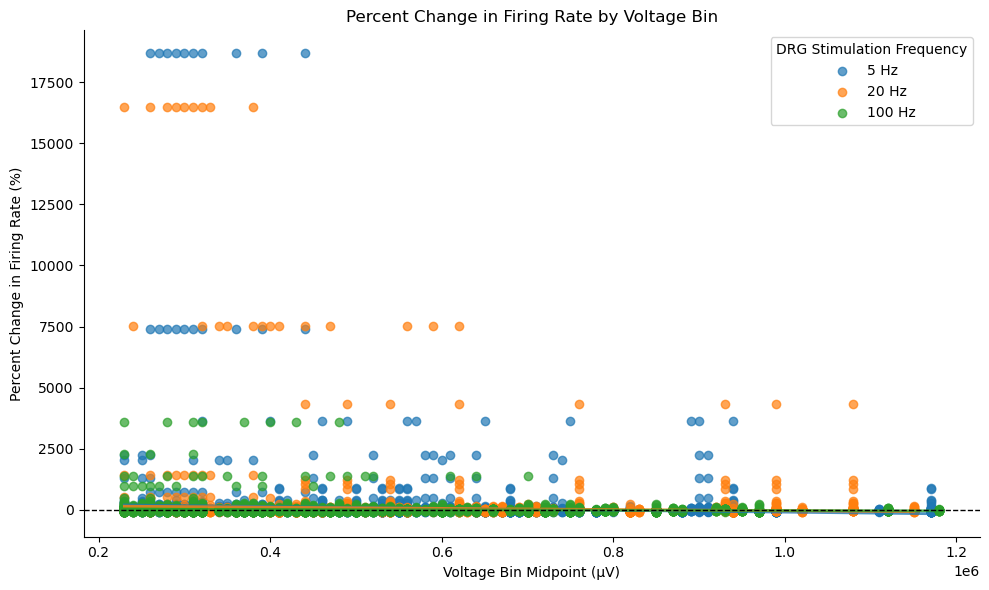

In [65]:
plot_percent_change(pre_post_pivot)

### DW323

In [66]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW323"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
11646,DW323,DW323_VF_2_240911_165039,2.0-DW323_VF_2_240911_165039,350000,20,14.765088,0.193548,7528.628952
11632,DW323,DW323_VF_2_240911_165039,2.0-DW323_VF_2_240911_165039,380000,20,14.765088,0.193548,7528.628952
11648,DW323,DW323_VF_2_240911_165039,2.0-DW323_VF_2_240911_165039,400000,20,14.765088,0.193548,7528.628952
11629,DW323,DW323_VF_2_240911_165039,2.0-DW323_VF_2_240911_165039,320000,20,14.765088,0.193548,7528.628952
11630,DW323,DW323_VF_2_240911_165039,2.0-DW323_VF_2_240911_165039,340000,20,14.765088,0.193548,7528.628952
...,...,...,...,...,...,...,...,...
15014,DW323,DW323_VF_4_240911_170446,17.0-DW323_VF_4_240911_170446,230000,100,0.000000,7.393939,-100.000000
15016,DW323,DW323_VF_4_240911_170446,17.0-DW323_VF_4_240911_170446,280000,100,0.000000,7.393939,-100.000000
15017,DW323,DW323_VF_4_240911_170446,17.0-DW323_VF_4_240911_170446,300000,100,0.000000,7.393939,-100.000000
15018,DW323,DW323_VF_4_240911_170446,17.0-DW323_VF_4_240911_170446,310000,100,0.000000,7.393939,-100.000000


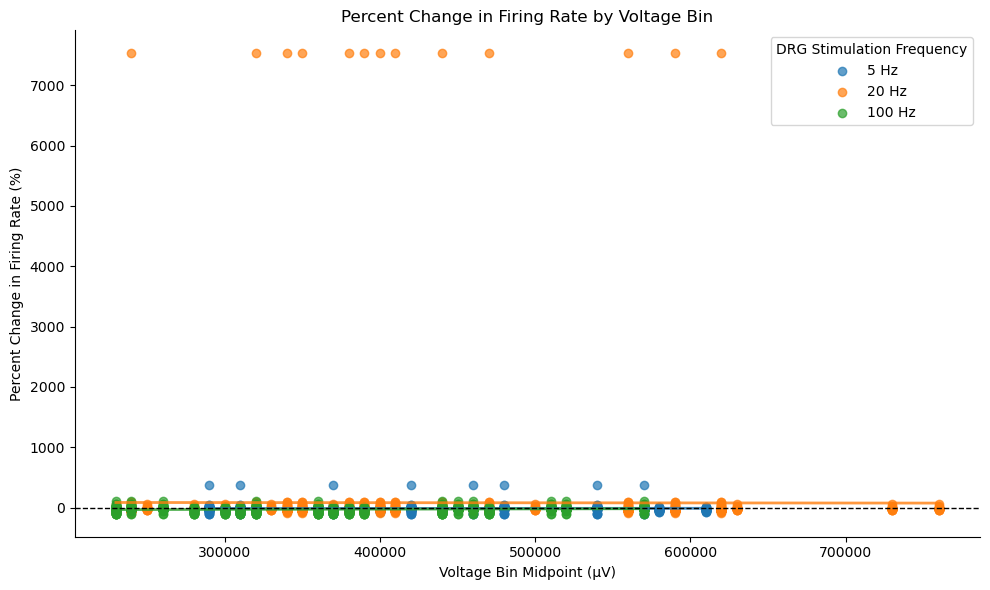

In [67]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW323"])

### DW327

In [68]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
17074,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,310000,5,12.95572,0.068966,18685.794285
17071,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,260000,5,12.95572,0.068966,18685.794285
17086,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,360000,5,12.95572,0.068966,18685.794285
17084,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,290000,5,12.95572,0.068966,18685.794285
17083,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,270000,5,12.95572,0.068966,18685.794285
...,...,...,...,...,...,...,...,...
20403,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,310000,100,0.00000,14.694948,-100.000000
20401,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,280000,100,0.00000,14.694948,-100.000000
20398,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,230000,100,0.00000,14.694948,-100.000000
18136,DW327,DW327_VF_03_241125_154841,18.0-DW327_VF_03_241125_154841,230000,100,0.00000,9.263749,-100.000000


In [69]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
17074,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,310000,5,12.95572,0.068966,18685.794285
17071,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,260000,5,12.95572,0.068966,18685.794285
17086,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,360000,5,12.95572,0.068966,18685.794285
17084,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,290000,5,12.95572,0.068966,18685.794285
17083,DW327,DW327_VF_01_241125_153746,1.0-DW327_VF_01_241125_153746,270000,5,12.95572,0.068966,18685.794285
...,...,...,...,...,...,...,...,...
20403,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,310000,100,0.00000,14.694948,-100.000000
20401,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,280000,100,0.00000,14.694948,-100.000000
20398,DW327,DW327_VF_08_241125_161626,7.0-DW327_VF_08_241125_161626,230000,100,0.00000,14.694948,-100.000000
18136,DW327,DW327_VF_03_241125_154841,18.0-DW327_VF_03_241125_154841,230000,100,0.00000,9.263749,-100.000000


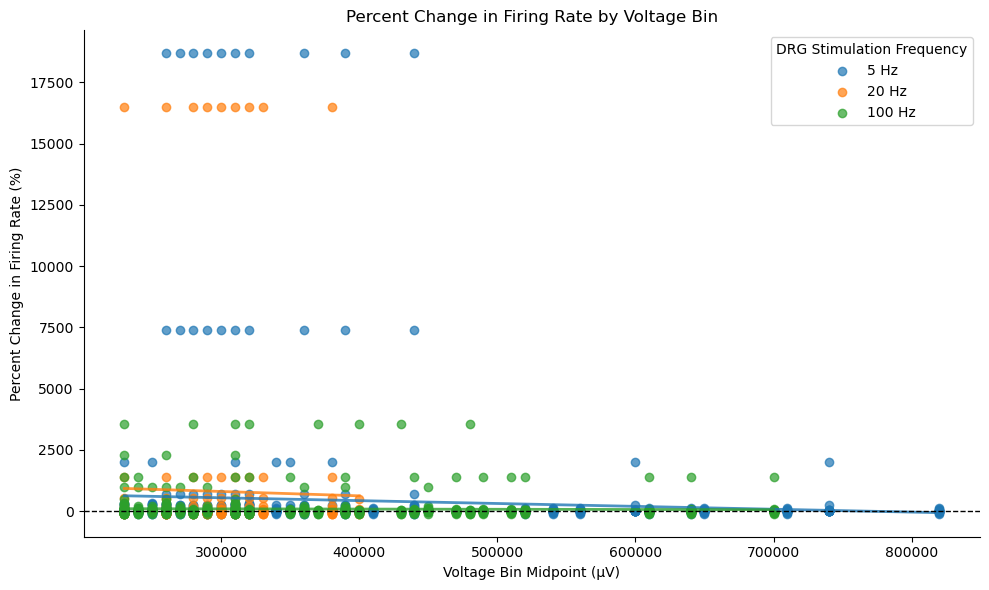

In [70]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"])

### DW322

In [71]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW322"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
5342,DW322,DW322_VF_5_240918_150137,7.0-DW322_VF_5_240918_150137,890000,5,39.636293,1.067532,3612.888692
5333,DW322,DW322_VF_5_240918_150137,7.0-DW322_VF_5_240918_150137,650000,5,39.636293,1.067532,3612.888692
5307,DW322,DW322_VF_5_240918_150137,7.0-DW322_VF_5_240918_150137,570000,5,39.636293,1.067532,3612.888692
5347,DW322,DW322_VF_5_240918_150137,7.0-DW322_VF_5_240918_150137,940000,5,39.636293,1.067532,3612.888692
5343,DW322,DW322_VF_5_240918_150137,7.0-DW322_VF_5_240918_150137,750000,5,39.636293,1.067532,3612.888692
...,...,...,...,...,...,...,...,...
2865,DW322,DW322_VF_3_240918_144658,0.0-DW322_VF_3_240918_144658,360000,100,0.000000,0.058824,-100.000000
2863,DW322,DW322_VF_3_240918_144658,0.0-DW322_VF_3_240918_144658,290000,100,0.000000,0.058824,-100.000000
2855,DW322,DW322_VF_3_240918_144658,0.0-DW322_VF_3_240918_144658,590000,100,0.000000,0.058824,-100.000000
2852,DW322,DW322_VF_3_240918_144658,0.0-DW322_VF_3_240918_144658,540000,100,0.000000,0.058824,-100.000000


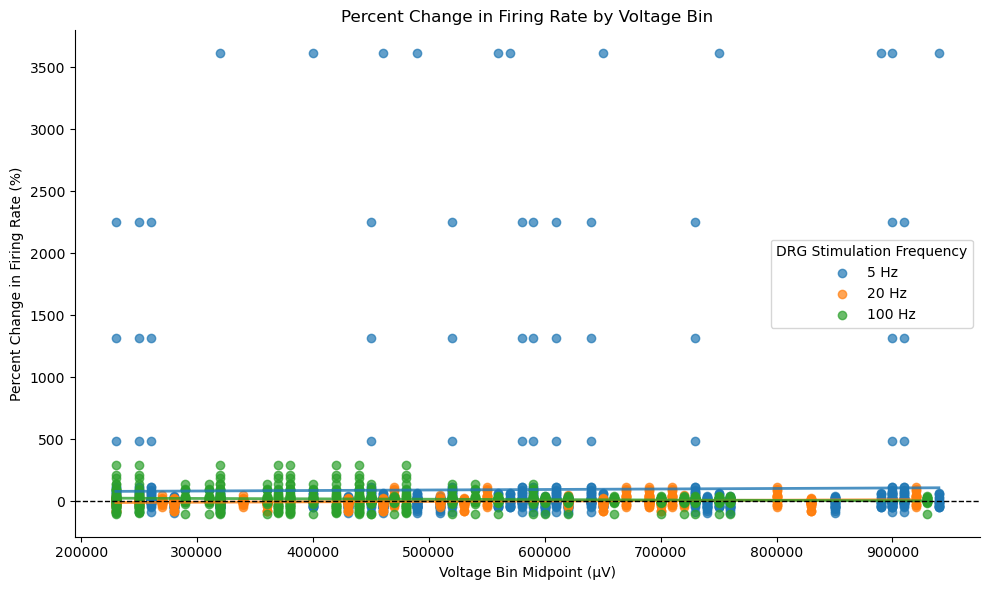

In [72]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW322"])

# 📈 linear mixed effects model - nested cluster, trial, rat id
---

MAKE SURE TO DO THIS STEP


when you filter by correlation threshhold, it is going to drop rows and some of the data may refer to old indices.  This can happen if you drop rows (for example, due to missing percent_change values) without resetting the index, so some groups still reference old index values.



this graph is hard to draw any conclusions from - plot the average trend, with std error bars

    #### structure of dataset

    * Rat
        * trial 
            * cluster ID

    #### Predictor/Fixed Variable:
    * Frequency_Hz (categorical: 5, 20, 100 Hz): frequency of DRG stimulation
    #### Random Effects:
    * Rat_ID: Differences in baseline firing changes between animals.
    * Trial_ID (nested within Rat_ID): Trial‐to‐trial variability (per animal).
    * Trial_Cluster: Variability at the neuron level (per trial).

**Model Formula:**

$$
\text{percent\_change\_firing} \sim \text{Frequency\_Hz} + (1 \mid \text{Rat\_ID}) + \{ \text{Trial}: 0 + C(\text{Trial\_ID}),\ \text{Neuron}: 0 + C(\text{Cluster}) \}
$$

#### methods

In [73]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(cluster)',
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz + voltage_bin", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_change
No. Observations: 13435   Method:             REML          
No. Groups:       4       Scale:              0.0000        
Min. group size:  1658    Log-Likelihood:     45023.8587    
Max. group size:  7175    Converged:          Yes           
Mean group size:  3358.8                                    
------------------------------------------------------------
               Coef.    Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept       60.355      9.364  6.446 0.000 42.002 78.707
Frequency_Hz    -0.570      0.154 -3.696 0.000 -0.873 -0.268
voltage_bin     -0.000      0.000 -0.000 1.000 -0.000  0.000
Neuron Var   59985.679 386180.846                           
Trial Var       66.465  40975.259                           



things that could be possible:

1. Multicollinearity - are Frequency and Voltage correlated?
2. Trial_ID cluster have only than one level per group.
3. Trial_ID cluster levels are not overly sparse or redundant with the fixed effects.

In [74]:
pre_post_pivot['Frequency_Hz'].describe()


count    13435.000000
mean        44.144771
std         43.025403
min          5.000000
25%          5.000000
50%         20.000000
75%        100.000000
max        100.000000
Name: Frequency_Hz, dtype: float64

In [75]:
pre_post_pivot['voltage_bin'].describe()

count    1.343500e+04
mean     5.453807e+05
std      2.110983e+05
min      2.300000e+05
25%      3.800000e+05
50%      5.200000e+05
75%      6.800000e+05
max      1.180000e+06
Name: voltage_bin, dtype: float64

In [76]:
pre_post_pivot[['Frequency_Hz', 'voltage_bin']].corr()

group,Frequency_Hz,voltage_bin
group,,
Frequency_Hz,1.00000,-0.06936
voltage_bin,-0.06936,1.00000


ok, so these values are not highly correlated. this tells me we don't have enough data then?

In [ ]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(Trial_ID):C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

In [ ]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Neuron': 'C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Trial_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())